In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import sys; sys.path.insert(0, '..')
import geopandas as gpd
import xarray, rioxarray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from rasterio import open
from rasterio.mask import mask
import matplotlib as mpl
from config import *
from rasterio.enums import Resampling

plt.rcParams['font.family'] = ['Palatino']
plt.rcParams['font.size'] = 14
%config InlineBackend.figure_format = 'retina'
year = 2019
eur = gpd.read_file(r"../data/cities/europe.geojson")

def get_cities(year):
    year = get_prior_year(year)
    return gpd.read_file(r"../data/cities/{}/clean/cities.geojson".format(year))


def get_prior_year(year):
    if year >= 2020:
        year = 2020
    elif (year >= 2015) and (year < 2020):
        year = 2015
    elif (year >= 2010) and (year < 2015):
        year = 2010
    elif (year >= 2005) and (year < 2010):
        year = 2005
    return year

cities = get_cities(year).rename(columns={'year': 'city_ref_year'})

In [2]:
pop = rioxarray.open_rasterio(r"../data/population/{}/pop.tif".format(year)).sel(band=1)
pop = pop.rio.write_nodata(np.nan)
pop = pop.rio.clip(eur.geometry.values)
pop.values = pop.values.astype(np.dtype("float32"))
pop.values[pop.values == pop.rio.nodata] = 0

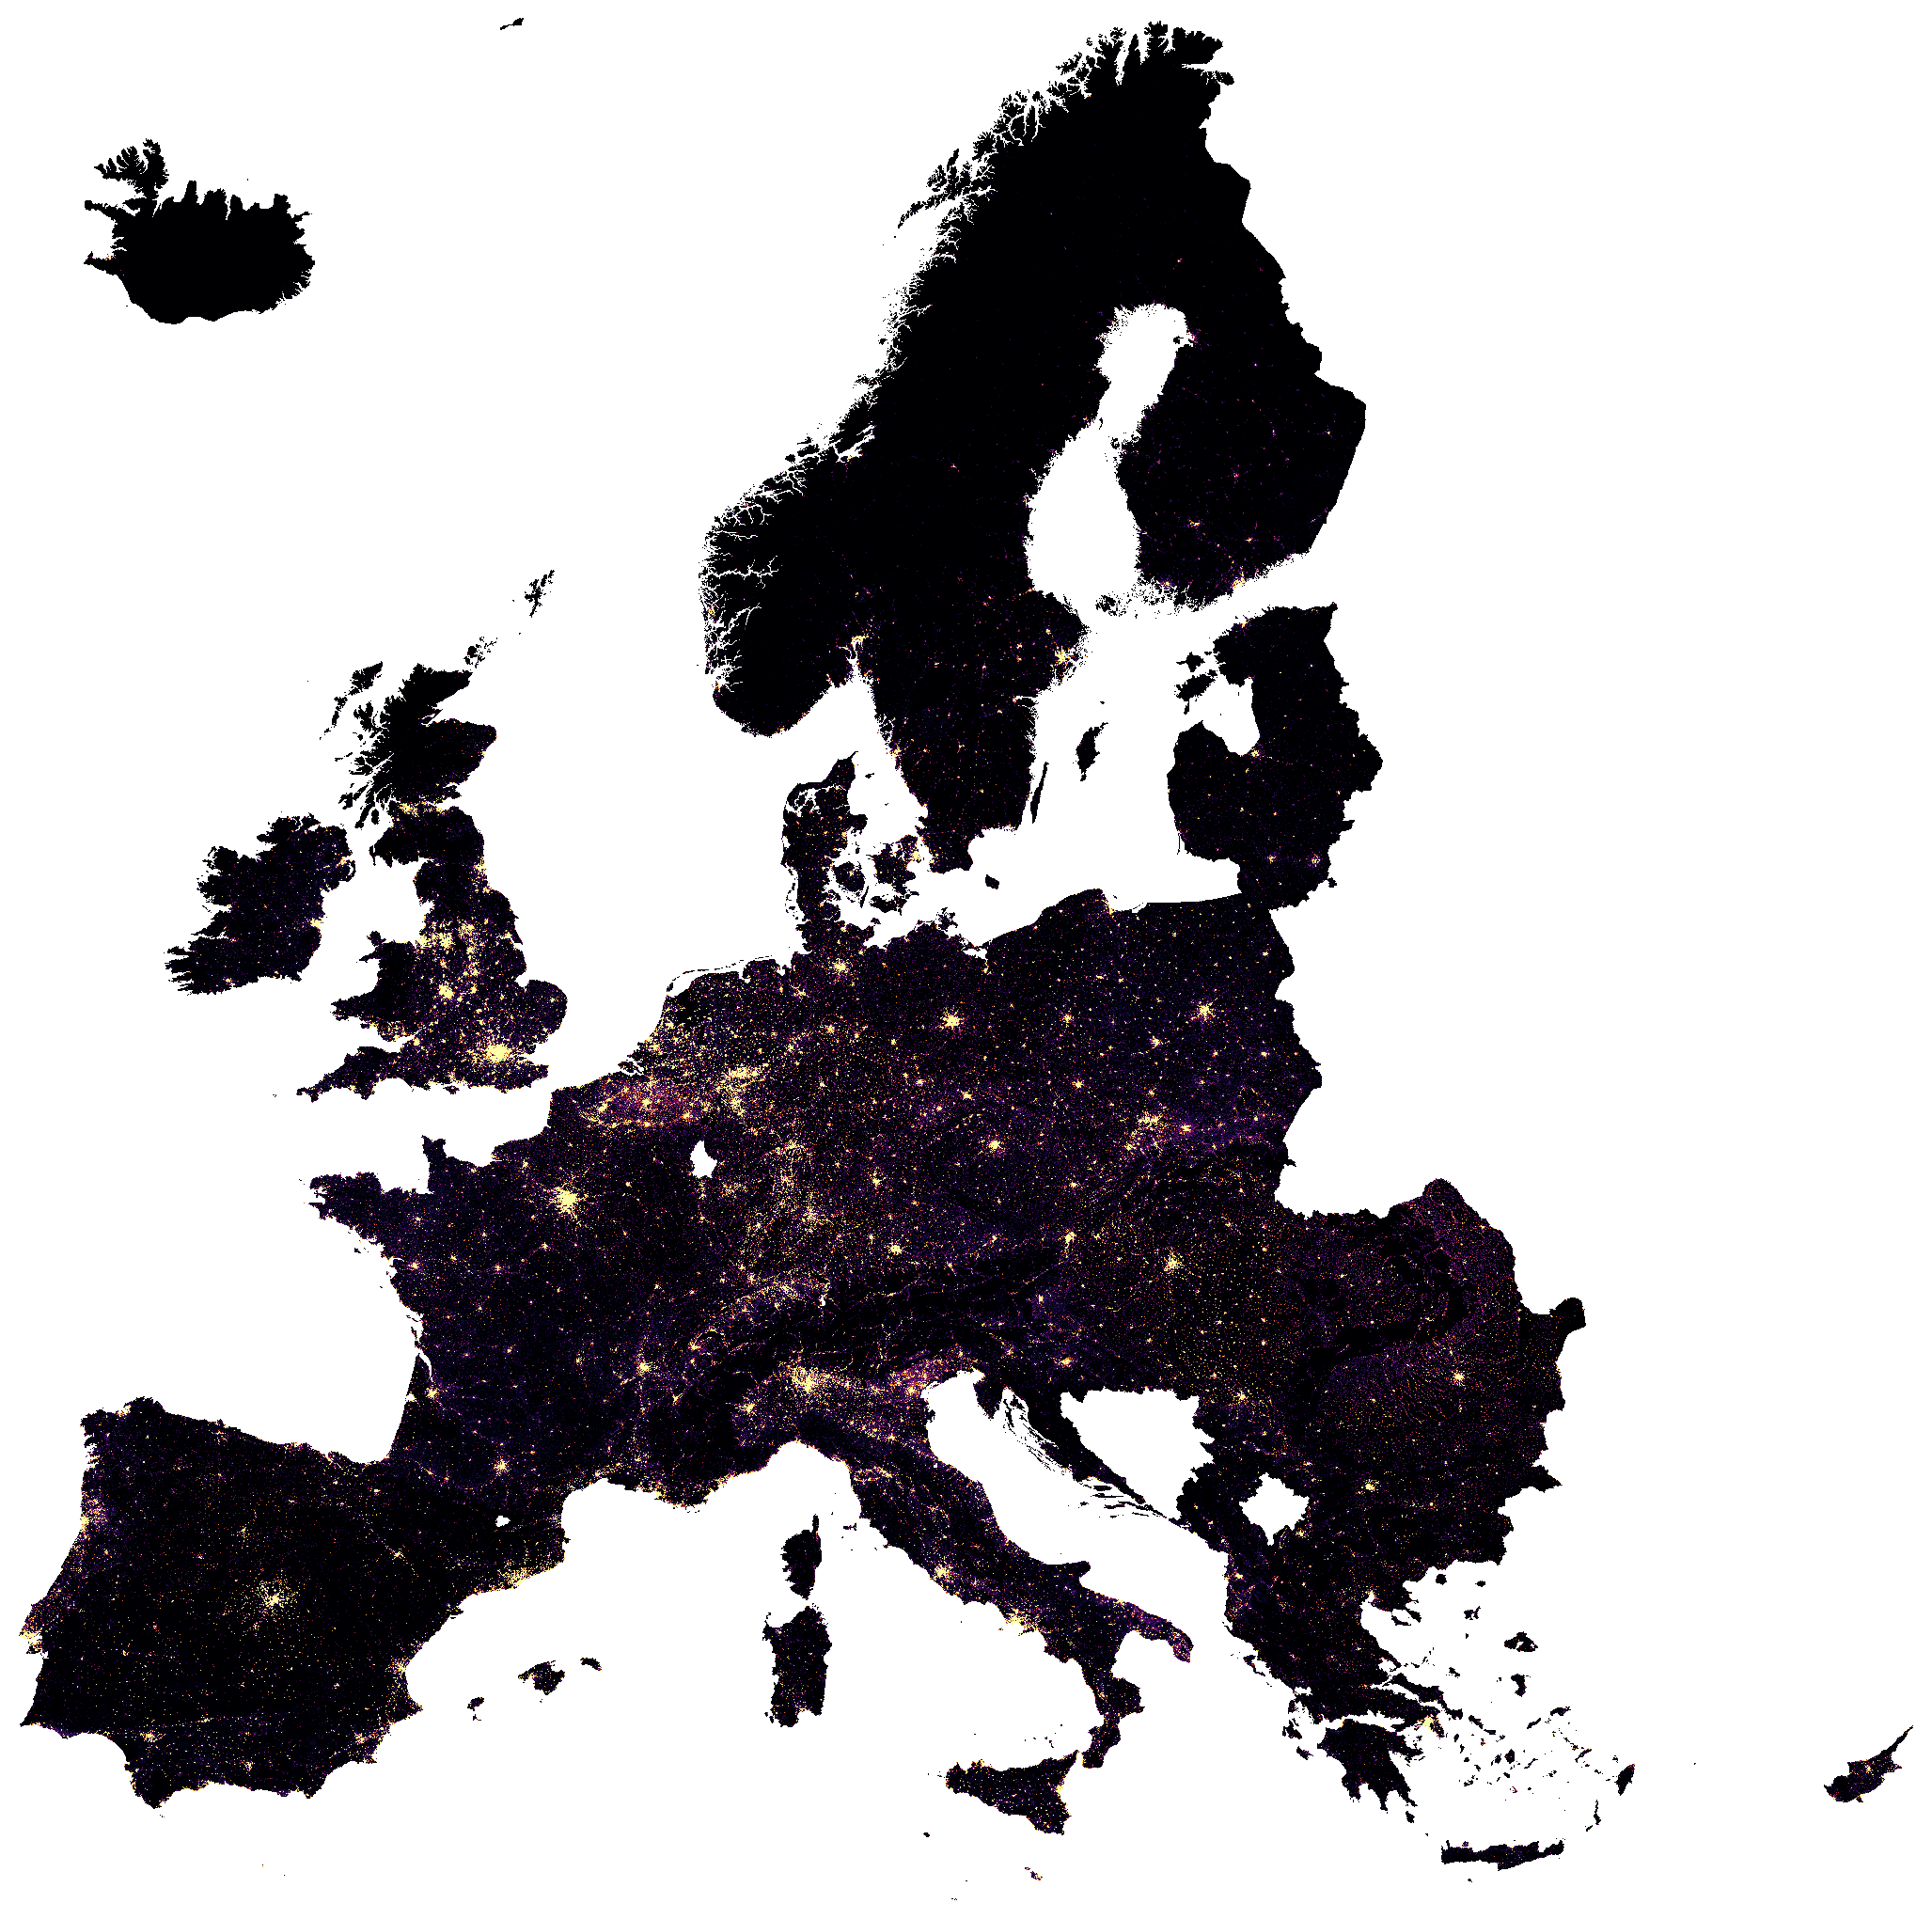

In [3]:
f, ax = plt.subplots(1, 1, figsize=(13, 13))
pop.plot.imshow(ax=ax, add_colorbar=False, robust=True, cmap='inferno')
# eur.boundary.plot(ax=ax, color='lightgreen', linewidth=0.15)
ax.set_axis_off();
ax.set_title("");
f.savefig(r"../figures/eurpop.png", dpi=300)

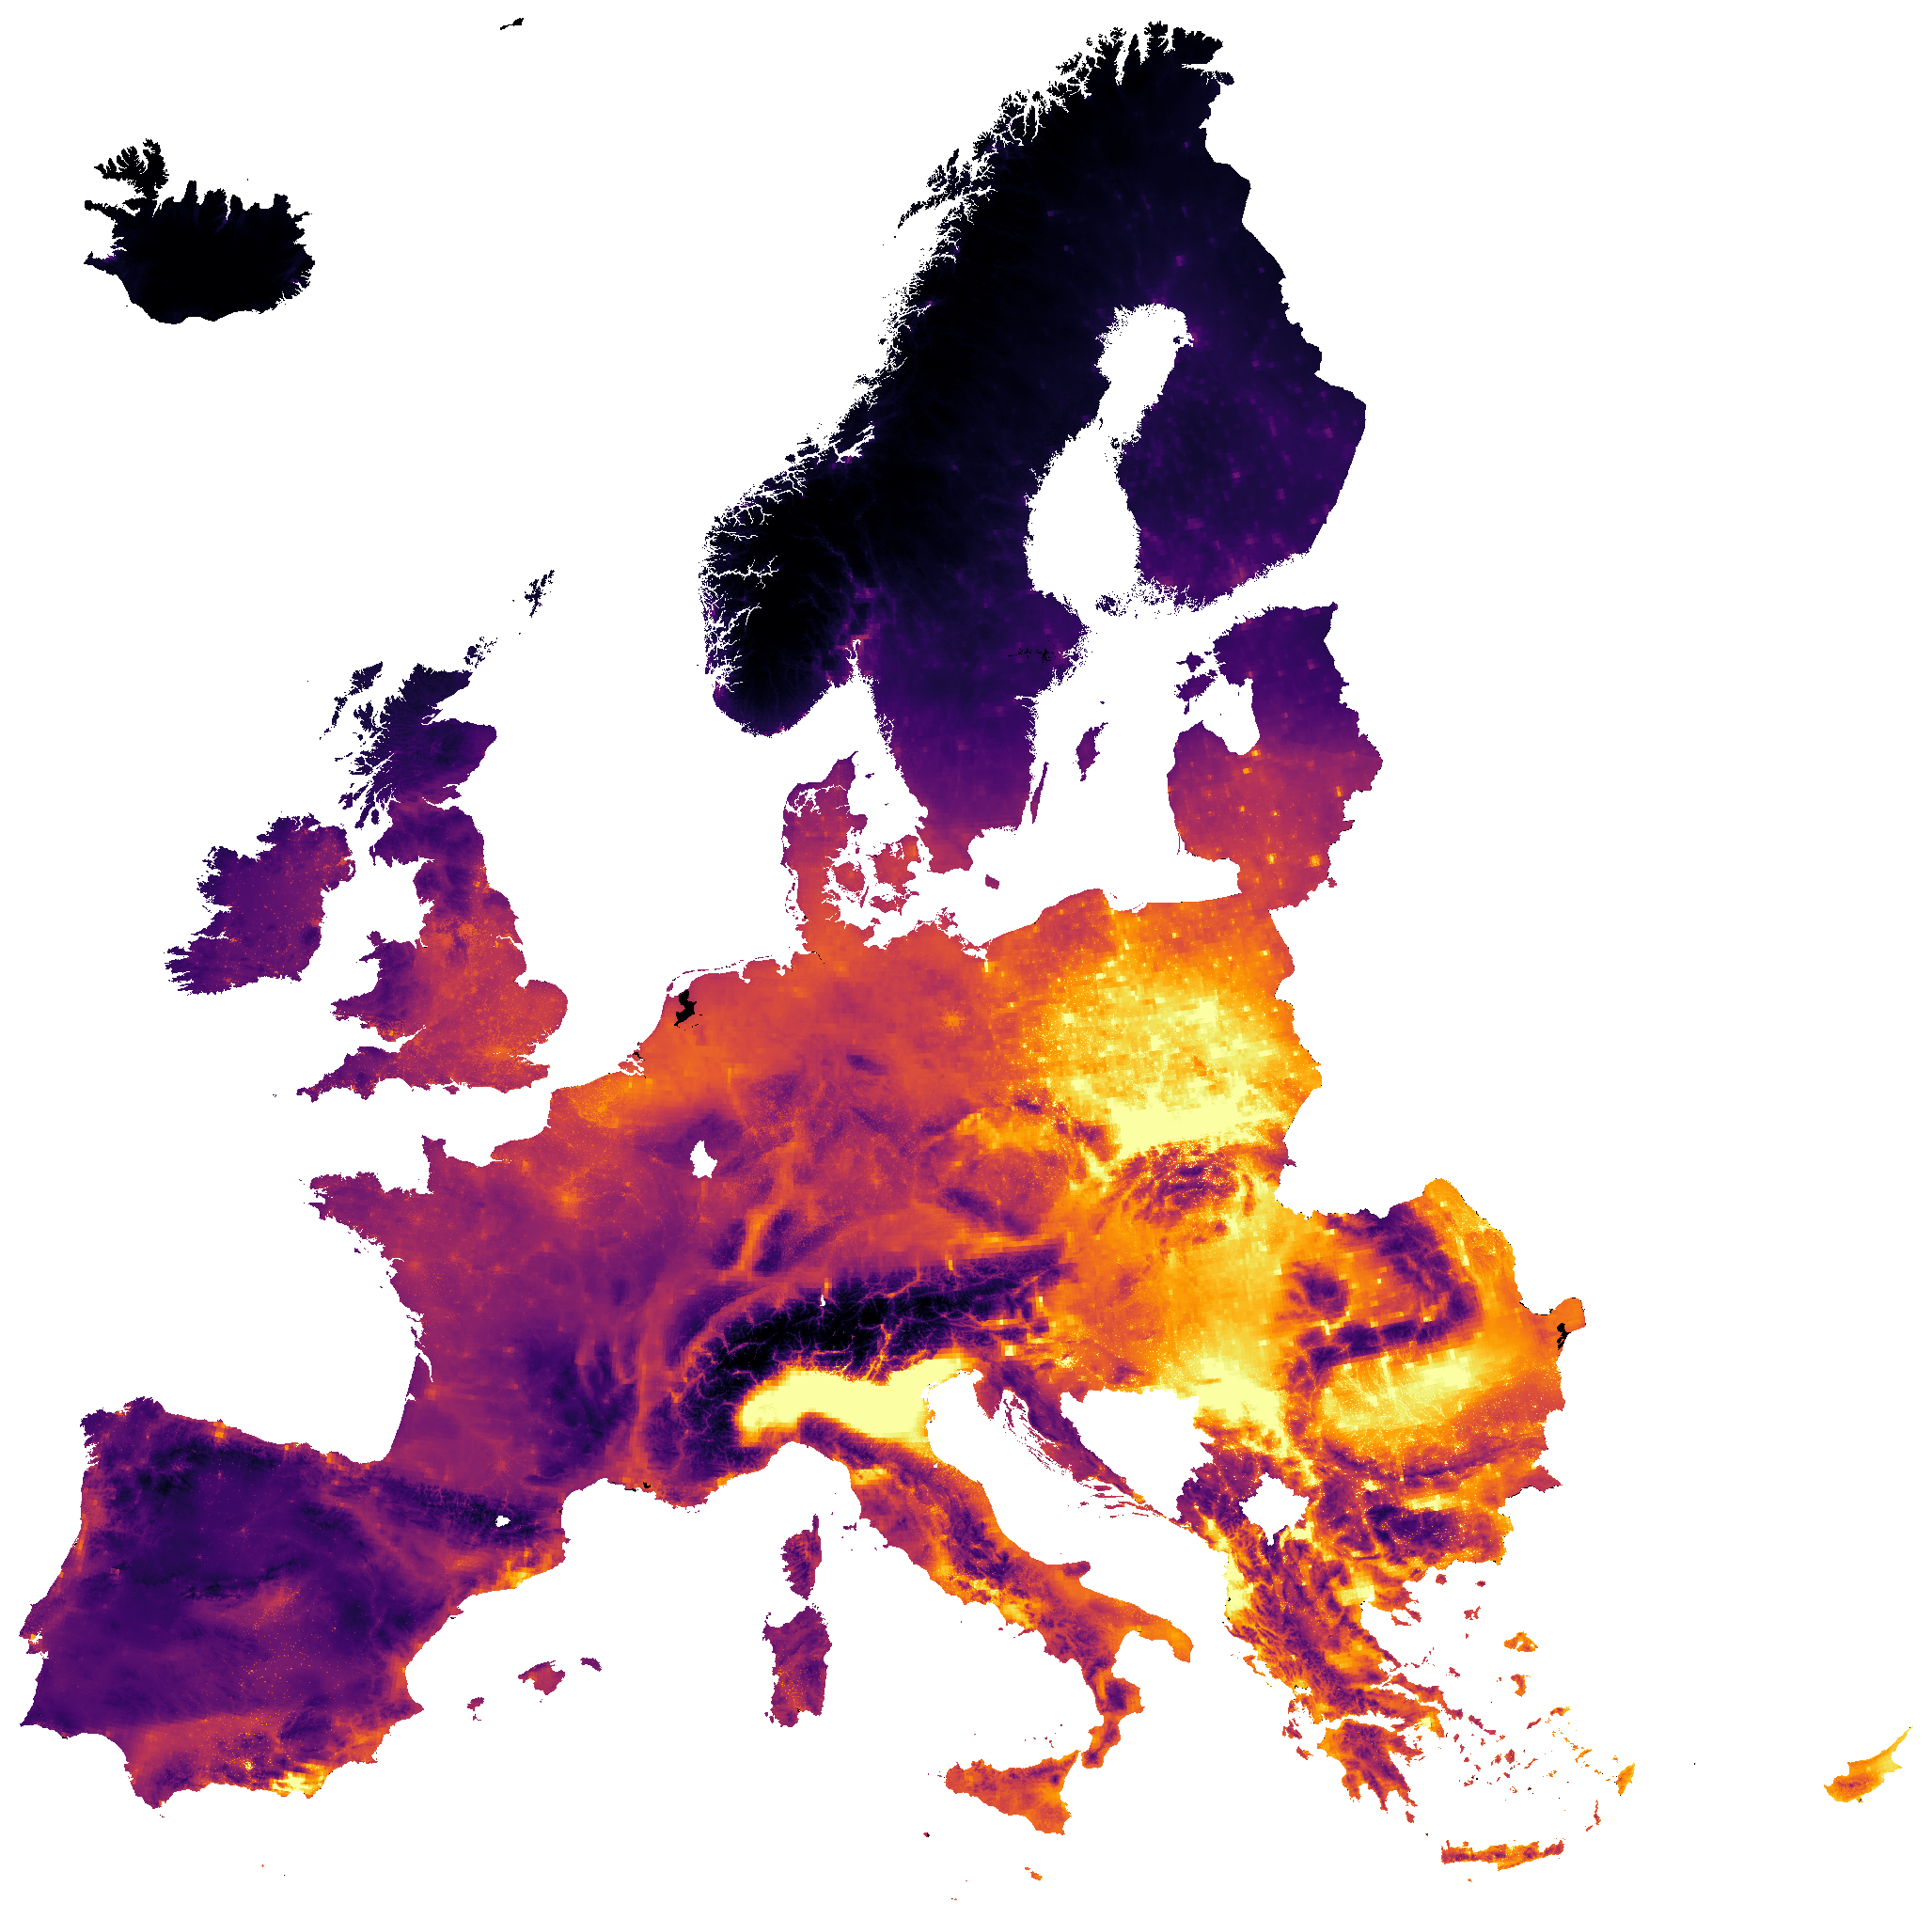

In [4]:
pol = rioxarray.open_rasterio(r"../data/pollution/{}/pol.tif".format(year)).sel(band=1)
pol = pol.rio.write_nodata(np.nan)
pol = pol.rio.clip(eur.geometry.values)
pol.values = pol.values.astype(np.dtype("float32"))
pol.values[pol.values == pol.rio.nodata] = 0
f, ax = plt.subplots(1, 1, figsize=(13, 13))
pol.plot.imshow(ax=ax, add_colorbar=False, robust=True, cmap='inferno')
ax.set_axis_off();
ax.set_title("");
f.savefig(r"../figures/eurpol.png", dpi=300)

In [5]:
from shapely.geometry import box
pop = rioxarray.open_rasterio(r"../data/population/{}/pop.tif".format(year)).sel(band=1)
city_dict = {"London": 685, "Paris": 241, "Milan": 101}
cr = cities.to_crs(4326)

/Users/nicoforteza/Desktop/gis_density/venv/lib/python3.9/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/nicoforteza/Desktop/gis_density/venv/lib/python3.9/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/nicoforteza/Desktop/gis_density/venv/lib/python3.9/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array

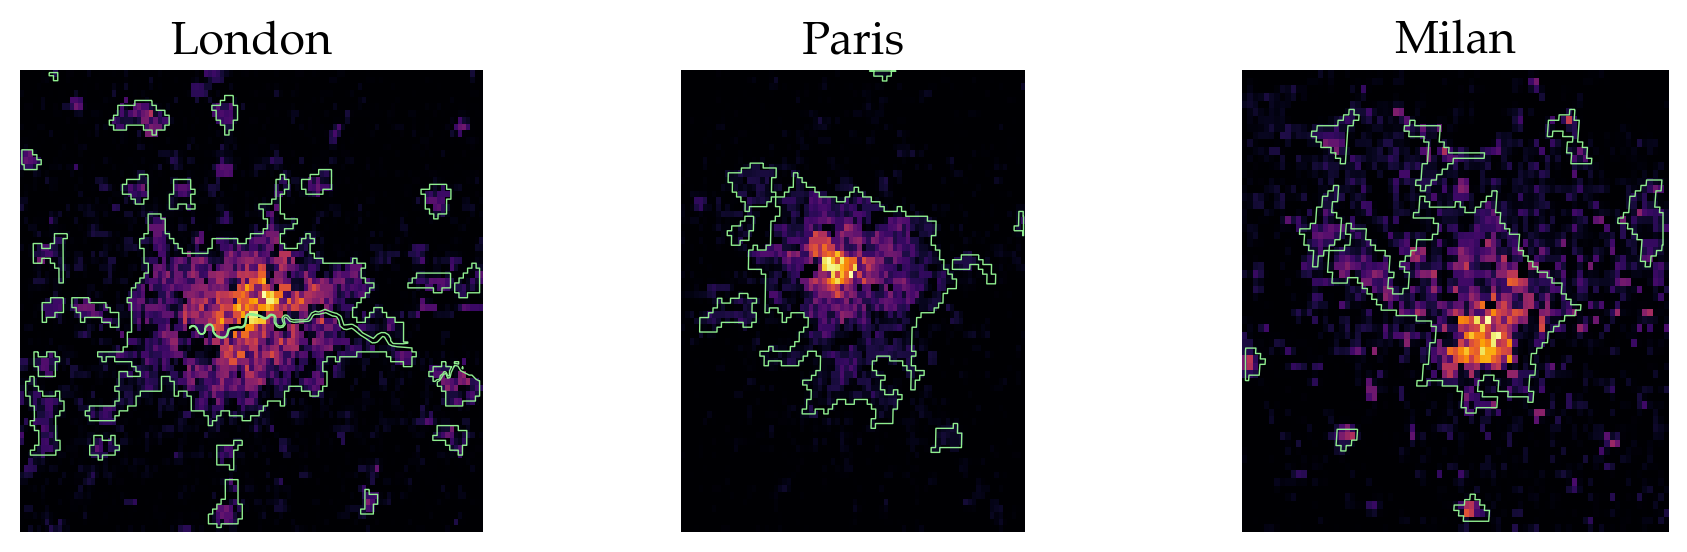

In [6]:
tol = 0.2
f, ax = plt.subplots(1, 3, figsize=(11, 3))

for i, xx in enumerate(ax.ravel()):

    city_name = list(city_dict)[i]
    city_id = list(city_dict.values())[i]
    city = cities[cities.id == city_id].to_crs(4326)
    bounds = city.total_bounds
    country_box = box(*bounds)
    buffered_box = country_box.buffer(tol)
    popr = pop.rio.reproject(4326)
    
    clipped_pop = popr.rio.clip_box(*buffered_box.bounds)
    clipped_pop.plot.imshow(ax=xx, add_colorbar=False, robust=False, cmap='inferno');
    cr.clip(buffered_box.bounds).boundary.plot(ax=xx, color='lightgreen', linewidth=0.5)
    xx.set_axis_off();
    xx.set_title(city_name);
f.savefig(r"../figures/cities_pop.png", dpi=300, pad_inches=0);

In [14]:
from shapely import Polygon, MultiLineString, MultiPolygon, LineString


def del_to_poly(x):
    if isinstance(x, Polygon) | isinstance(x, MultiPolygon):
        return x
    elif isinstance(x, MultiLineString) | isinstance(x, LineString):
        return x.convex_hull

cities = gpd.read_file(r"../data/cities/{}/clean/cities.geojson".format(2020)).to_crs(4326)
lzes = gpd.read_file(r"../data/uar/uar_data.geojson")
lzes["geometry"] = lzes.geometry.apply(del_to_poly)

In [15]:
id_ = 281

In [16]:
city = cities[cities.id == id_]

In [17]:
polr = pol.rio.reproject(4326)

/Users/nicoforteza/Desktop/gis_density/venv/lib/python3.9/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


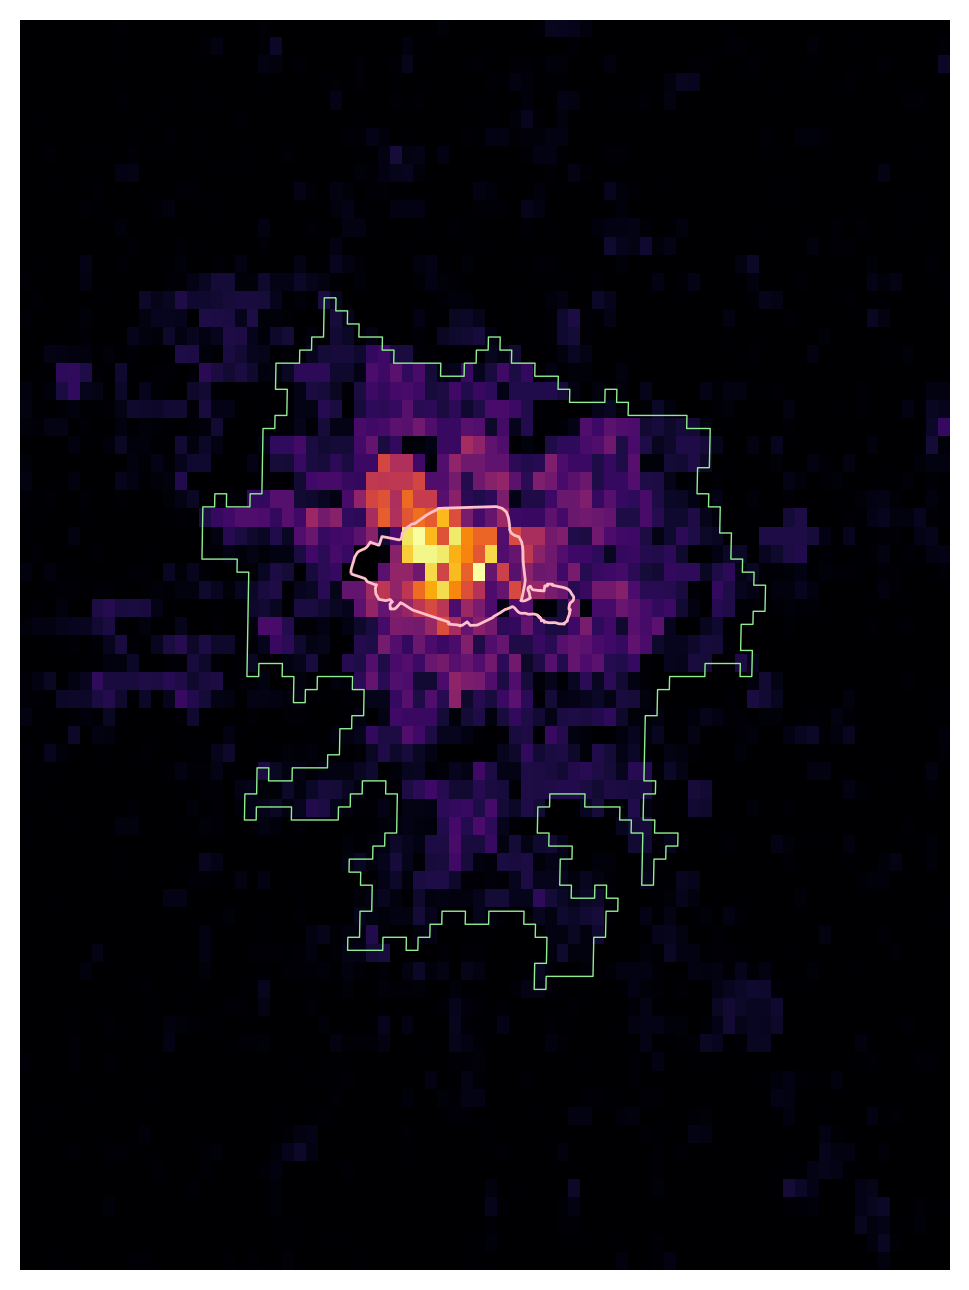

In [18]:
f, ax = plt.subplots(1, 1, figsize=(6, 9))

bounds = city.total_bounds
country_box = box(*bounds)
buffered_box = country_box.buffer(tol)
popr = pop.rio.reproject(4326)

clipped_pop = popr.rio.clip_box(*buffered_box.bounds)
clipped_pop.plot.imshow(ax=ax, add_colorbar=False, robust=False, cmap='inferno');
city.clip(buffered_box.bounds).boundary.plot(ax=xx, color='lightgreen', linewidth=0.5)
city.boundary.plot(ax=ax, color='lightgreen', linewidth=0.5)
lzes[lzes.id == id_].boundary.plot(ax=ax, color='pink', linewidth=1)

ax.set_axis_off();
ax.set_title("");
f.savefig(r"../figures/paris_lez.png", dpi=300, pad_inches=0);

In [12]:
lze = lzes[lzes.id == id_]
city = cities[cities.id == id_].to_crs(4326)
lze = lze.to_crs(4326)

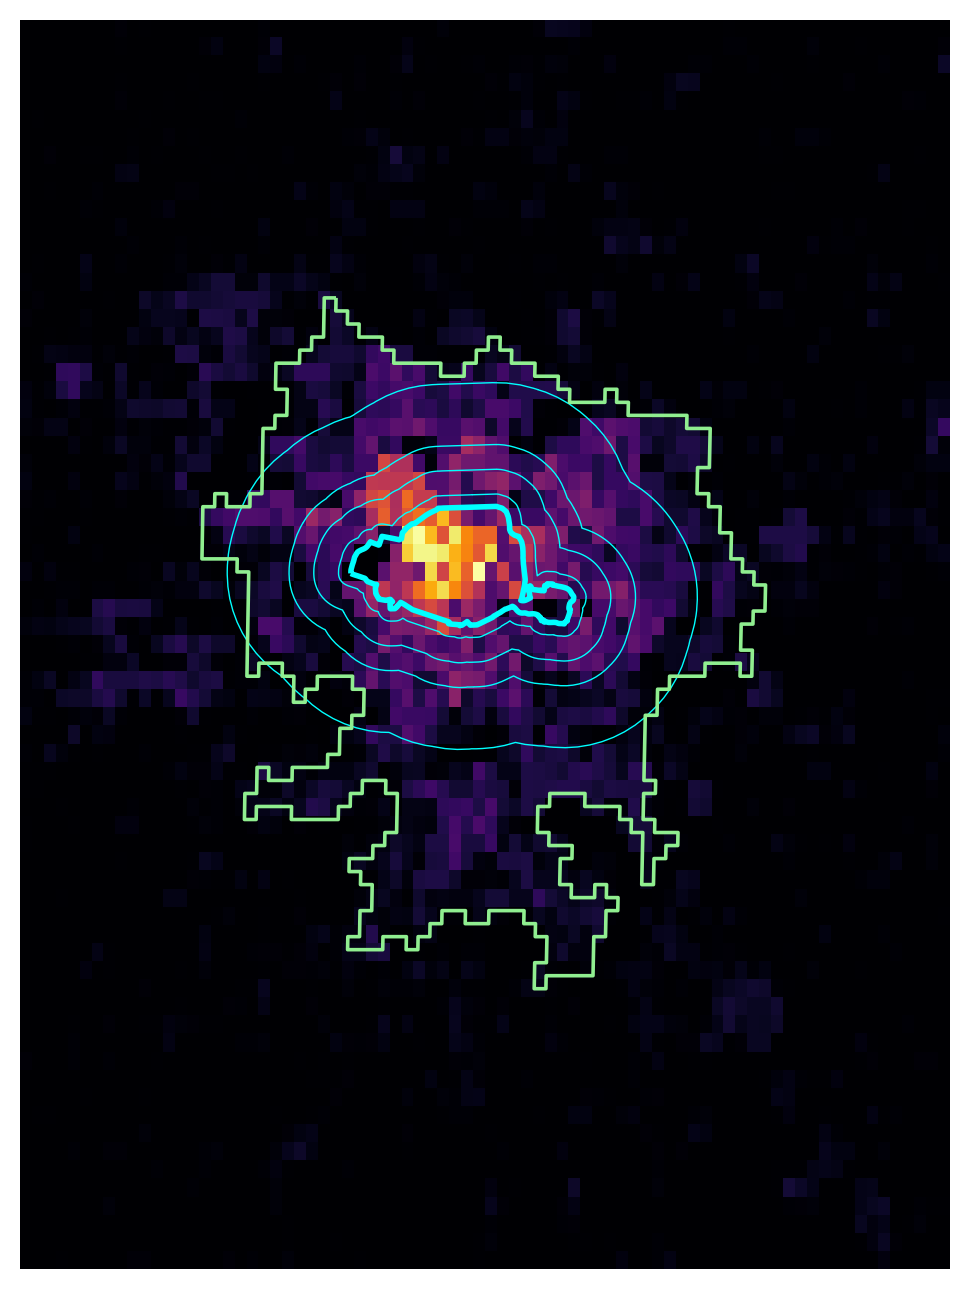

In [13]:
f, ax = plt.subplots(1, 1, figsize=(6, 9))
ring_size = [1e3, 3e3, 5e3, 10e3]
lze.boundary.plot(color='cyan', ax=ax, linewidth=2)
for ring in ring_size:
    lze.to_crs(3035).buffer(ring).to_crs(4326).boundary.plot(color='cyan', ax=ax, linewidth=.5)
    
bounds = city.total_bounds
country_box = box(*bounds)
buffered_box = country_box.buffer(tol)
popr = pop.rio.reproject(4326)

clipped_pop = popr.rio.clip_box(*buffered_box.bounds)
clipped_pop.plot.imshow(ax=ax, add_colorbar=False, robust=False, cmap='inferno');
city.boundary.plot(ax=ax, color='lightgreen', linewidth=1.3)    

ax.set_axis_off();
ax.set_title("");
f.savefig(r"../figures/paris_lez_spillovers.png", dpi=300, pad_inches=0);